In [1]:
%reload_ext autoreload
%autoreload 2
from collections import namedtuple
import file_utility
import os
import pandas as pd

import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import json
import pickle
import spikeinterfaceHelper
from tqdm import tqdm
import numpy as np
import setting
import logging
from types import SimpleNamespace
import matplotlib.pylab as plt

18:30:08 [I] klustakwik KlustaKwik2 version 0.2.6


### Define file paths

In [2]:
sinput = SimpleNamespace()
soutput = SimpleNamespace()

sinput.recording_to_sort = 'E:/open-ephys-testdata/M1_D20-45'

#make output folder
try:
    os.mkdir(sinput.recording_to_sort+'/processed/')
except FileExistsError:
    print('Folder already there')
    
sinput.probe_file =   'sorting_files/tetrode_16.prb'
sinput.sort_param = 'sorting_files/params.json'
sinput.tetrode_geom = 'sorting_files/geom_all_tetrodes_original.csv'
sinput.dead_channel = sinput.recording_to_sort +'/dead_channels.txt'

soutput.sorter_df = sinput.recording_to_sort +'/processed/sorted_df.pkl'
soutput.sorter_curated_df = sinput.recording_to_sort +'/processed/sorted_curated_df.pkl'

soutput.waveform_figure = sinput.recording_to_sort+'/processed'

Folder already there
C:\Users\teristam\Anaconda3\envs\spikeforest\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Loading files

In [3]:
signal = file_utility.load_OpenEphysRecording(sinput.recording_to_sort)
geom = pd.read_csv(sinput.tetrode_geom, header=None).values
bad_channel = file_utility.getDeadChannel(sinput.dead_channel)

Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...


### Creating extractor and filtering

In [4]:
Fs = 30000
recording = se.NumpyRecordingExtractor(signal[:,:Fs*180],setting.sampling_rate,geom)
recording = recording.load_probe_file(sinput.probe_file) #load probe definition
recording = st.preprocessing.remove_bad_channels(recording, bad_channel_ids=bad_channel) #remove bad channel
recording_f = st.preprocessing.bandpass_filter(recording, freq_min=300, freq_max=6000)


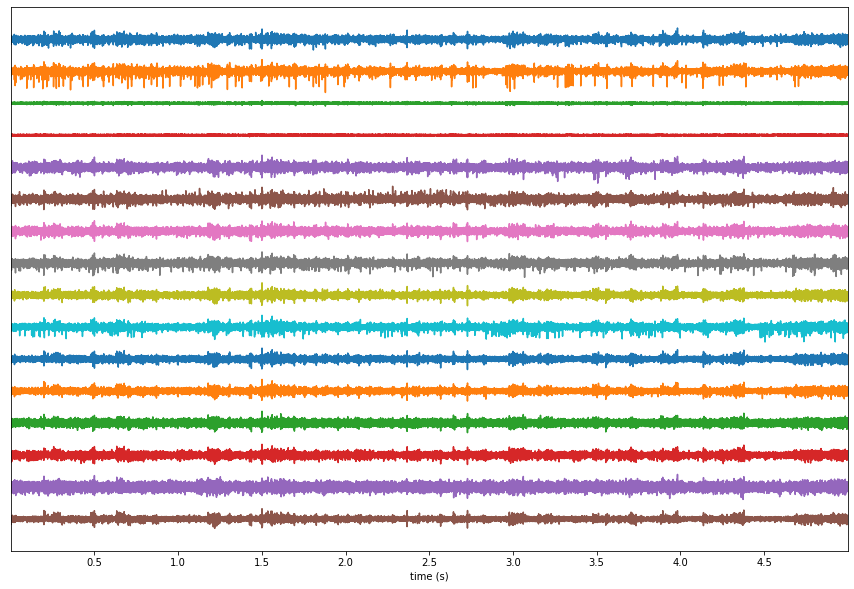

In [5]:
fig,ax = plt.subplots(figsize=(15,10))
sw.plot_timeseries(recording_f,trange=[0,5],ax=ax)

### Sort recordings

In [7]:
# sorting
%env TEMPDIR=C:\tmp
ms4_params = ss.get_default_params('mountainsort4')
ms4_params['curation']=True
# ms4_params['adjust_radius']  = 100
sorting_MS4_2 = ss.run_mountainsort4(recording=recording,output_folder='sorting_tmp',verbose=True, **ms4_params)

C:\Users\teristam\Anaconda3\envs\spikeforest\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
env: TEMPDIR=C:\tmp
WARNING! The recording contains several group. In order to spike sort by 'group' use grouping_property='group' as argument.
Using 2 workers.
Using tmpdir: C:\tmp\tmpe28jhb99
Num. workers = 2
Preparing C:\tmp\tmpe28jhb99/timeseries.hdf5...
Preparing neighborhood sorters (M=16, N=5400000)...
Preparing output...
Done with ms4alg.
Cleaning tmpdir::::: C:\tmp\tmpe28jhb99
Curating


KeyboardInterrupt: 

In [6]:
sorting_KL = ss.run_klusta(recording=recording)

WARNING! The recording contains several group. In order to spike sort by 'group' use grouping_property='group' as argument.
RUNNING SHELL SCRIPT: d:\Documents\GitHub\spikeforest_comparison\klusta_output\run_klusta.bat


SpikeSortingError: Spike sorting failed: 'charmap' codec can't decode byte 0x8f in position 34: character maps to <undefined>. You can inspect the runtime trace in the klusta.log of the output folder.'

### Calculate some sorting metrics

In [8]:
st.postprocessing.get_unit_max_channels(recording, sorting_ms4, max_spikes_per_unit=100)
st.postprocessing.get_unit_waveforms(recording, sorting_ms4, max_spikes_per_unit=100)

for id in sorting_ms4.get_unit_ids():
    number_of_spikes = len(sorting_ms4.get_unit_spike_train(id))
    mean_firing_rate = number_of_spikes/(recording._recording._timeseries.shape[1]/setting.sampling_rate)
    sorting_ms4.set_unit_property(id,'number_of_spikes',number_of_spikes)
    sorting_ms4.set_unit_property(id, 'mean_firing_rate', mean_firing_rate)


### Save sorted result

In [27]:
session_id = sinput.recording_to_sort.split('/')[-1]
sorter_df=spikeinterfaceHelper.sorter2dataframe(sorting_ms4,session_id)
sorter_df.to_pickle(soutput.sorter_df)

### Curate sortings

In [13]:
sorting_ms4_curated = st.curation.threshold_snr(sorting=sorting_ms4, recording = recording,
  threshold =2, threshold_sign='less', max_snr_spikes_per_unit=100, apply_filter=False) #remove when less than threshold
print(sorting_ms4_curated.get_unit_ids())

sorting_ms4_curated=st.curation.threshold_firing_rate(sorting_ms4_curated,
    threshold=0.5, threshold_sign='less')
print(sorting_ms4_curated.get_unit_ids())

sorting_ms4_curated=st.curation.threshold_isi_violations(sorting_ms4_curated, threshold = 0.9)
print(sorting_ms4_curated.get_unit_ids())

sorting_ms4_curated = st.curation.threshold_firing_rate(sorting=sorting_ms4_curated,threshold=0.5,threshold_sign='less')
print(sorting_ms4_curated.get_unit_ids())


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21]
[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21]
[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21]


### Save curated data

In [28]:
#save curated data
curated_sorter_df = spikeinterfaceHelper.sorter2dataframe(sorting_ms4_curated, session_id)
curated_sorter_df.to_pickle(soutput.sorter_curated_df)

### plot spike waveforms

In [29]:
plot_waveforms(curated_sorter_df, soutput.waveform_figure)

  0%|          | 0/18 [00:00<?, ?it/s]

I will plot the waveform shapes for each cluster.


100%|██████████| 18/18 [00:16<00:00,  1.10it/s]
